# Synthetic Control For Amazon Product A/B Testing

### Before I start,
I want to acknowledge that this notebook is heavily inspired by the content of [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html).\
A major part of this notebook's code (and explanations) is taken from his open-source book.\
Another main resource I used is [Causal Inference: The Mixtape](https://mixtape.scunning.com/synthetic-control.html)
and some of the explanations were taken from this [article](https://towardsdatascience.com/causal-inference-using-synthetic-control-the-ultimate-guide-a622ad5cf827).



### Objective:
In this notebook, I'm going to examine if a change we did in one of our products on Amazon helped increase sales or not. \
I'm going to use Synthetic Control Method with a few custom changes in the procedure.\
**It's Important to mention** that because I'm doing changes in the process this is **not** exactly Synthetic Control, but I'm using the same logic of this procedure.\
The main differences are that I'm using regression with regularization (Elastic-Net) without any restrictions on the weights like the author uses.\
In order to prevent overfitting, I'm doing hyperparameter optimization with cross-validation that is stable for a time series task. 
     



### The Expariment:
In May 2021, we took one of our products on Amazon and combine it with another product into one multi-list.\
Here is example to illustrate the case - **this is a random product, not ours** - \
imagine we took this single [chef knif](https://www.amazon.com/J-Henckels-International-Forged-16901-201/dp/B001S41SH6/ref=sr_1_59_sspa?keywords=one+chef+knife+and+set&qid=1637327356&sr=8-59-spons&psc=1&spLa=ZW5jcnlwdGVkUXVhbGlmaWVyPUEyMlNRN0VLRkRST1QxJmVuY3J5cHRlZElkPUEwODg4MDA4MVlIVzA0OFNLVDFSQSZlbmNyeXB0ZWRBZElkPUEwNTE0MTI0MUhPQllMRERPT0RCQiZ3aWRnZXROYW1lPXNwX2J0ZiZhY3Rpb249Y2xpY2tSZWRpcmVjdCZkb05vdExvZ0NsaWNrPXRydWU=)
and combine it with other list of [chef knifs](https://www.amazon.com/Zwillilng-J-Henckels-8-Inch-Stainless-Steel/dp/B00004RFKS?ref_=ast_sto_dp&th=1&psc=1) with different lengths (but basically very similar). \
We assumed the history of sales and reviews of the single product will improve the other one and will create a better list in general. 



### The Problem:

The problem of checking our hypothesis, is that we can't do "classic" A\B testing. \
We can't make a change in a list and show it only to one part of the potential buyers while the other part will see the original product on Amazon,\
and make a comparison. In other words, we can't divide our observation into treatment and control groups. \
So we won't be able know if our intervention caused a change in the product's sales or it would have happened anyway.



### The Method - Synthetic Control:

The first appearance of the synthetic control estimator was a 2003 article where it was used to estimate the impact of terrorism on economic activity ([Abadie and Gardeazabal 2003](https://www.jstor.org/stable/3132164)). Since that publication, it has become very popular and later on, Abadie, Diamond, and Hainmueller ([2010](https://economics.mit.edu/files/11859)) expound on the method by using a cigarette tax in California called Proposition 99.


The Synthetic Control Method uses a weighted average of multiple cases from the “donor” pool to create an artificial control case.\
Here is a simplified process:
1. There are J + 1 units (products in our case).
2. The j(1) is the treated case units, from j(2) to j(j+1) are unexposed cases that constitute the “donor pool” (other products in our case).
3. pool from the donors and get a weighted average of the units.
pick the weighted value, W*, that minimizes the following loss function:
$||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}$

    Subject to the restriction that w2,…,wJ+1 are non-negative and sum to one.
    

4. Multiply these weights with the X dataset values and receive the synthetic unit.

### The Data

The data I used is a daily sales (quantity) of 203 related products which also partially correlated with our target product, but also represent the market trends and behavior. These time series contain only quantities and dates from 2017 until 2021, because of confidential issues I won't share the dataset in this repo.

# Import Packages

In [76]:
import pandas as pd
import numpy as np
import warnings

from joblib import Parallel, delayed
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

from matplotlib import style
from matplotlib import pyplot as plt

import optuna
from optuna.samplers import TPESampler


from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

%matplotlib inline

optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

# Import The Data

In [77]:
data = pd.read_csv(r'C:\Users\tomer\Downloads\data.csv',parse_dates =['date'])

# Clean the data and preprocess for model

The treatment product we combine with other product is Product 10001.

In [78]:
# Trim observations of other products that occurred before the treatment product has been created
first_created = data.loc[data['product_id'] == 'Product 10001',['date']].min()[0]
df = data[data['date'] >= first_created].sort_values(by='date')

# For each product group the quantities by months
grouper = pd.Grouper(key='date', freq='M')
df = df.groupby(['product_id',grouper]).agg(
    quantity=pd.NamedAgg(column='quantity', aggfunc='sum')
    ).reset_index()

df.drop(df[df['date']>='2021-10-31'].index,inplace =True) # The data of October is not complete 

# Reshape the df for Standart scaling by product id
df = df.pivot(index='product_id', columns='date').T.fillna(0)
df.head()

product_id           Product 10001  Product 10002  Product 10003  ...  \
         date                                                     ...   
quantity 2017-01-31            2.0            0.0           82.0  ...   
         2017-02-28            2.0            3.0          105.0  ...   
         2017-03-31            6.0            2.0           83.0  ...   
         2017-04-30            1.0            2.0           49.0  ...   
         2017-05-31            6.0            5.0           61.0  ...   

product_id           Product 10201  Product 10202  Product 10203  
         date                                                     
quantity 2017-01-31           16.0            5.0            5.0  
         2017-02-28           12.0            0.0            5.0  
         2017-03-31           20.0            1.0           10.0  
         2017-04-30           24.0            4.0           17.0  
         2017-05-31           25.0            7.0           17.0  

[5 rows x 203 columns]

This graph shows the behavior, in terms of quantity sold, of our treatment product (Product 10001) across time.

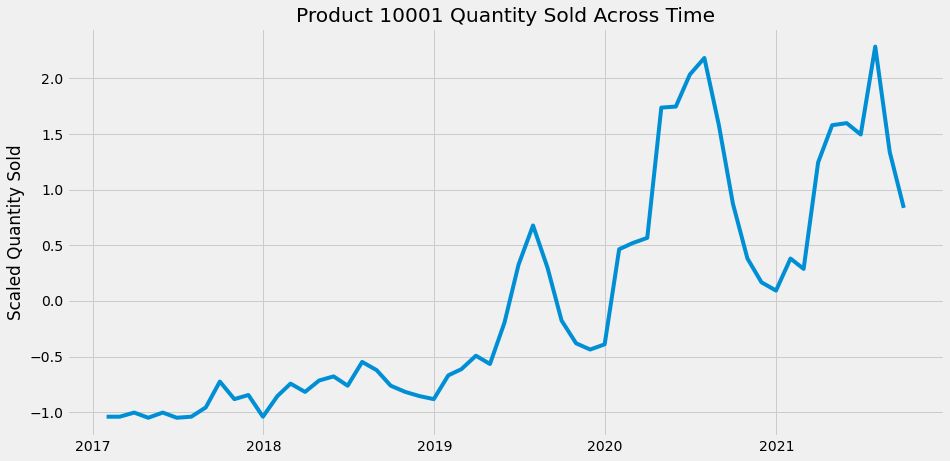

In [79]:
plt.figure(figsize=(14,7))

qty_sacle = (df['Product 10001'].values - np.mean(df['Product 10001'].values))/np.std(df['Product 10001'].values)

plt.plot(df['Product 10001'].index.get_level_values(1),qty_sacle)

plt.title("Product 10001 Quantity Sold Across Time")
plt.ylabel("Scaled Quantity Sold");

In [80]:
# Save columns' name and index
columns = df.columns
dates = df.index.get_level_values(1)

# Standard Scaling: (Xi-mean)/stdev
scaler = StandardScaler()
df = scaler.fit_transform(df)

# Adding columns name and index, from earlier, on the scaled values
df = pd.DataFrame(df,columns = columns)
df.index = dates

# Change the shape again for creating the variables
df = df.unstack().T.reset_index()
df = df.rename(columns={0: "quantity"})
df.head()

,product_id,date,quantity
0,Product 10001,2017-01-31,-1.040928
1,Product 10001,2017-02-28,-1.040928
2,Product 10001,2017-03-31,-1.003776
3,Product 10001,2017-04-30,-1.050216
4,Product 10001,2017-05-31,-1.003776


On May, we did a change and combine a product with `Product 10001`. Because we deal with aggregation data by months, the "after treatment" period starts in June 2021.
-  `after_change`: Dummy variable that indicates whether the observation accrued before or after the change. 
- `treatment_group`:  Dummy variable that indicates whether the observation is the product we changed (Product 10001) or other.


Now, we are going to build a predictive model using the data **before the change**, in order to forecast the treatment product quantity using the other products' quantities.


In [81]:
df['after_change'] = np.where(df.date >='2021-06-01',1,0) # the exact date is 2021-05-27
df['treatment_group'] = np.where(df['product_id'] == 'Product 10001',1,0) 

features = ['quantity'] # basically could be with more features but different scaling is required (and more data)
inverted = (df[df['after_change']==0].pivot(index='product_id', columns='date')[features].T)

y = inverted['Product 10001'].values 
X = inverted.drop(columns='Product 10001').values 

### **Model:**
In the [original study](https://www.aeaweb.org/articles?id=10.1257/000282803321455188), the author uses linear regression subject to the restriction that all the wights (the regression's coeficients) are non-negative and sum to one. 

I chose to use the [ElasticNet model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which is a linear regression with combined L1 and L2 priors as regularizer, without the restriction of the weights to be non-negative and sum to one.

The objective function to minimize is in this case:

### **Model Loss Function:**
$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +
\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}$ 


### **Metric:**
Root Mean Squaerd Error ( RMSE ):\
 $\text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2}.$    


### **Hyperparameter Tuning**
In order to prevent overfitting, I'm doing hyperparameter optimization with the Bayesian optimization approach using [Optuna framework](https://optuna.org/).

### **Cross Validation:**
I'm going to do cross-validation stable for a time series task using sklearn library. \
Time Series cross-validator - [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit): 
Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set. 

I'm splitting the data into 13 groups, and each group contains 4 months like the "after_change" period we will try to forecast later.

To avoid an irrelevant and long piece of code to visualize it, see attached Photo: 

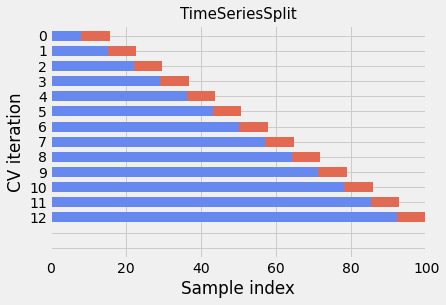





In [82]:
%%time

def objective(trial):
        params_grid = {
            'l1_ratio':trial.suggest_float('l1_ratio',0,1),
            'alpha': trial.suggest_float('alpha',0,10),
            'fit_intercept' : trial.suggest_categorical('fit_intercept',[True,False]),
            'positive' : trial.suggest_categorical('positive',[True,False]),
            
        }
        model = ElasticNet(**params_grid)
        model.fit(X, y) 
        
        time_split = TimeSeriesSplit(n_splits=round(inverted.shape[0]/4)) # trained to predict 4 months batch (13 splits) 
        result = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=time_split, n_jobs=-1)
        return -result.mean()
    
    
study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=1))
study.optimize(objective, n_trials=300)

best_params = study.best_params
print(best_params)

{'l1_ratio': 0.1455588961013002, 'alpha': 0.05564962173923037, 'fit_intercept': False, 'positive': False}
Wall time: 20.9 s


Here we can see how many trials it takes to get a sufficient RMSE value.

In [83]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [84]:
weights = ElasticNet(**best_params).fit(X, y).coef_

multi_synth_lr = (df[df['treatment_group']==0]
                  .pivot(index='date', columns="product_id")["quantity"]
                  .values.dot(weights))

In [85]:
print('RMSE: '+str((((df.loc[(df['treatment_group']==1)&(df["after_change"]==0),'quantity'] - multi_synth_lr[:-4]) ** 2).mean())**0.5))

RMSE: 0.09311802947951917


We can see the model fit well (but doesn't overfit), and the synthetic product has the same behaver like the real one in the pre intervention period.
We can also notice that after the treatment, the "new product" sold more than the synthtic which reprsent how much the product would have sold without the treatment.

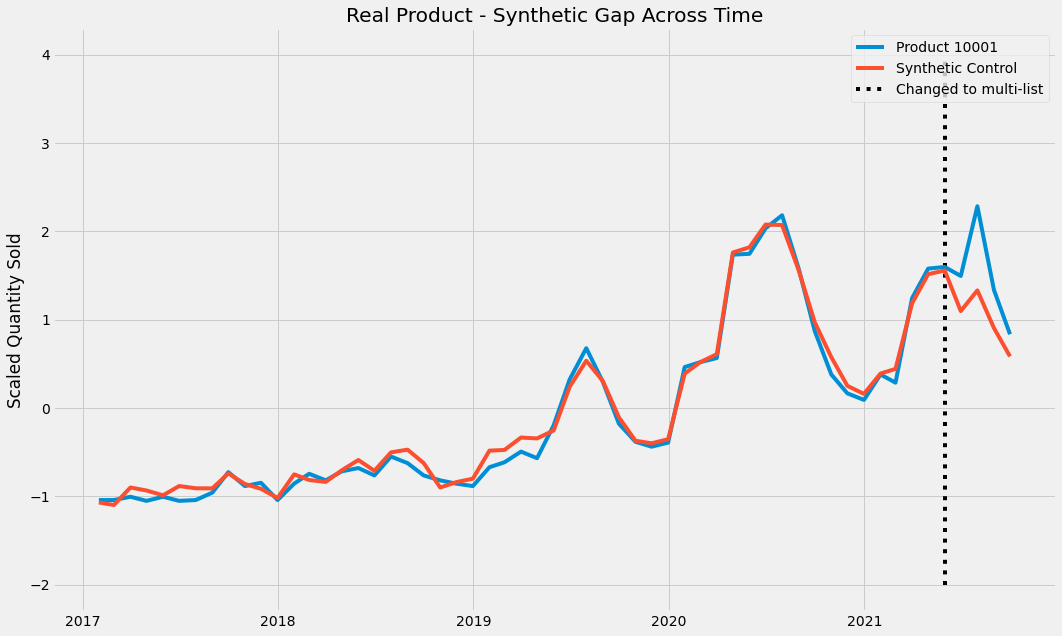

In [86]:
plt.figure(figsize=(16,10))
plt.plot(df.loc[df['treatment_group']==1,'date'], df.loc[df['treatment_group']==1,'quantity'], label="Product 10001")
plt.plot(df.loc[df['treatment_group']==1,'date'], multi_synth_lr, label="Synthetic Control")
plt.vlines(x=pd.to_datetime(['2021-05-31']), ymin=-2, ymax=4, linestyle=":", lw=4, color='black', label="Changed to multi-list")
plt.title("Real Product - Synthetic Gap Across Time")
plt.ylabel("Scaled Quantity Sold")
plt.legend();

We can estimate the treatment effect as the gap between treated and the synthetic control outcomes.
This graph shows the gap between the syntetic produdct and the real product.
We can see the new policy (combine one product to another) in this case increas the sales.

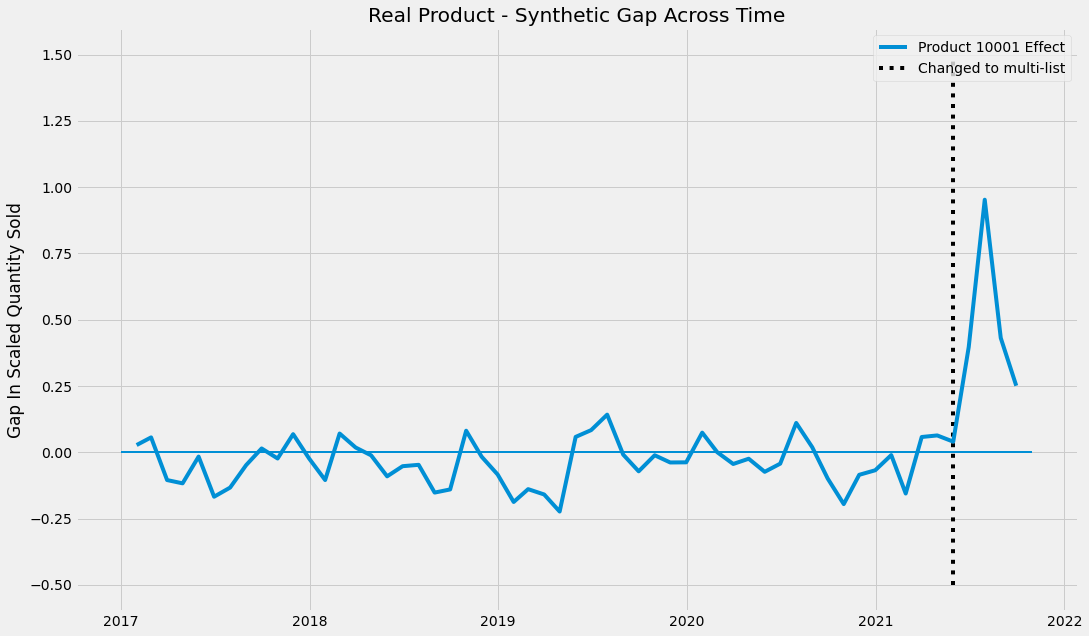

In [87]:
plt.figure(figsize=(16,10))
plt.plot(df.loc[df['treatment_group']==1,'date'], df.loc[df['treatment_group']==1,'quantity'] - multi_synth_lr,
         label="Product 10001 Effect")
plt.vlines(x=pd.to_datetime(['2021-05-31']), ymin=-0.5, ymax=1.5, linestyle=":", lw=4, color='black', label="Changed to multi-list")
plt.hlines(y=0, xmin=pd.to_datetime(['2017-01-01']), xmax=pd.to_datetime(['2021-10-31']), lw=2)
plt.title("Real Product - Synthetic Gap Across Time")
plt.ylabel("Gap In Scaled Quantity Sold")
plt.legend();

Figuring out if our result is not just due to random luck. We are going to repeat this process for all the other products and just change the treated and control the product in each process. This would mean that, for each product, we pretend it is the treated while the others are the control.

eventually, we will have one synthetic control and effect estimates for each product. So what this does is it pretends that the treatment actually happened for another product, not Product 10001, and see what would have been the estimated effect for this treatment that didn’t happen. Then, we see if the treatment in Product 10001 is sufficiently larger when compared to the others fake treatments.

In [88]:
def synthetic_control(product_id, pool, df):
    
    features = ['quantity']

    inverted = (df[df['after_change']==0].pivot(index='product_id', columns="date")[features].T) 
    
    y = inverted[str(product_id)].values # treated
    X = inverted.drop(columns=str(product_id)).values # donor pool
    
    def objective(trial):
        params_grid = {
            'l1_ratio':trial.suggest_float('l1_ratio',0,1),
            'alpha': trial.suggest_float('alpha',0,10),
            'fit_intercept' : trial.suggest_categorical('fit_intercept',[True,False]),
            'positive' : trial.suggest_categorical('positive',[True,False])
            
        }
        model = ElasticNet(**params_grid)
    
        
        time_split = TimeSeriesSplit(n_splits=round(inverted.shape[0]/4))
        result = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=time_split, n_jobs=-1)
        return -result.mean()
    
    
    study = optuna.create_study(direction='minimize',sampler=TPESampler(seed=1))
    study.optimize(objective, n_trials=300) 
    best_params = study.best_params

    weights = ElasticNet(**best_params).fit(X, y).coef_
    synthetic = df[df['treatment_group']==0].pivot(index='date', columns="product_id")["quantity"].values.dot(weights)

    return df.loc[(df['product_id']==product_id),["product_id", "date", "quantity", "after_change"]].assign(synthetic=synthetic)

In [89]:
# A list of all our products in the donor pool 
control_pool = df.loc[df['treatment_group'] == 0,"product_id"].unique().tolist()

# Example of the process for Product 10002
synthetic_control('Product 10002', control_pool, df).head()

,product_id,date,quantity,after_change,synthetic
57,Product 10002,2017-01-31,-0.490670,0,-0.626305
58,Product 10002,2017-02-28,-0.456381,0,-0.414273
59,Product 10002,2017-03-31,-0.467810,0,-0.468385
60,Product 10002,2017-04-30,-0.467810,0,-0.460778
61,Product 10002,2017-05-31,-0.433522,0,-0.452465


In [90]:
%%time

parallel_fn = delayed(partial(synthetic_control, pool=control_pool, df=df))
synthetic_products = Parallel(n_jobs=8)(parallel_fn(product) for product in control_pool)

Wall time: 31min 7s


In the next graph, we can see the gap between the real and the syntetic product across for each product in our donor pool.

Since there are products that poorly fit, it is a good idea to remove them from the analysis. One way to do it objectively is to set a threshold for pre-intervention error

$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$    


and remove those product with high error - I choose threshold of maximum 3 times larger than Product 10001 MSE.

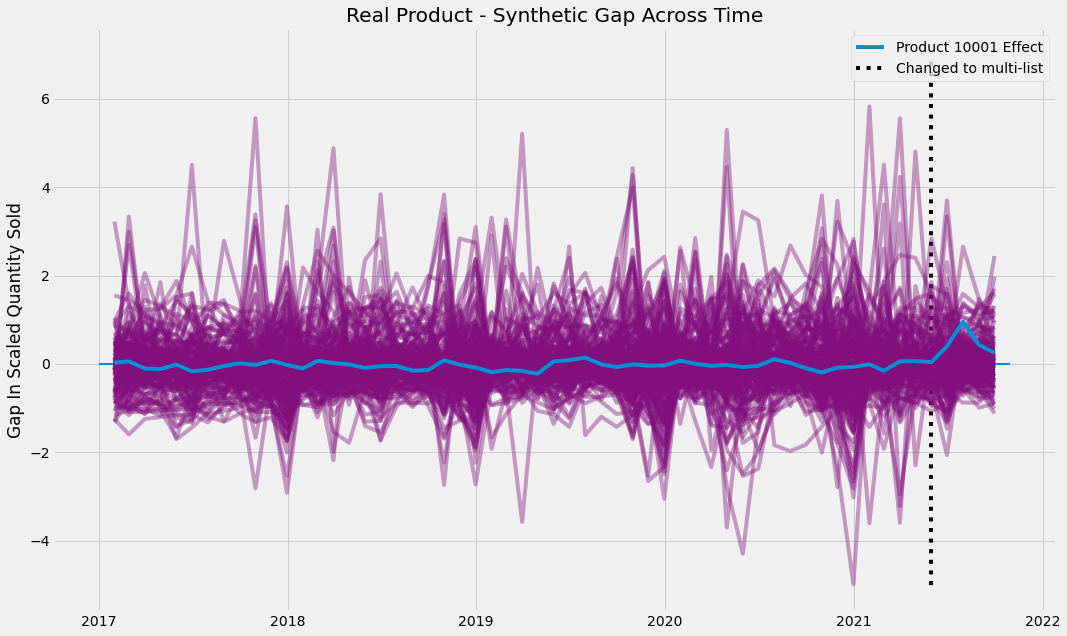

In [91]:
plt.figure(figsize=(16,10))

for product in synthetic_products:
    plt.plot(product["date"], product["quantity"] - product["synthetic"], color="C5",alpha=0.4)

plt.plot(df.loc[df['treatment_group']==1,'date'], df.loc[df['treatment_group']==1,'quantity'] - multi_synth_lr,
         label="Product 10001 Effect")
plt.vlines(x=pd.to_datetime(['2021-05-30']), ymin=-5, ymax=7, linestyle=":", lw=4, color='black', label="Changed to multi-list")
plt.hlines(y=0, xmin=pd.to_datetime(['2017-01-01']), xmax=pd.to_datetime(['2021-10-30']), lw=2)
plt.title("Real Product - Synthetic Gap Across Time")
plt.ylabel("Gap In Scaled Quantity Sold")
plt.legend(loc='upper right' );

In [92]:
mse_10001 = ((df.loc[(df['treatment_group']==1)&(df["after_change"]==0),'quantity'] - multi_synth_lr[:-4]) ** 2).mean()

print("Product 10001 MSE: " + str(round(mse_10001,4)),'\n'
       "Threshold: "+str(round(mse_10001*3,4)))

Product 10001 MSE: 0.0087 
Threshold: 0.026


In [93]:
def pre_treatment_mse(product):
    pre_treat_error = (product.loc[product["after_change"]==0,"quantity"] - product.loc[product["after_change"]==0,"synthetic"]) ** 2
    return pre_treat_error.mean()

Removing the noise, we can see how extreme of a value is the effect in the Product 10001. This graph shows us that if we pretend the treatment had happened to any other product, we would almost never get an effect so extreme as the one we got with Product 10001.

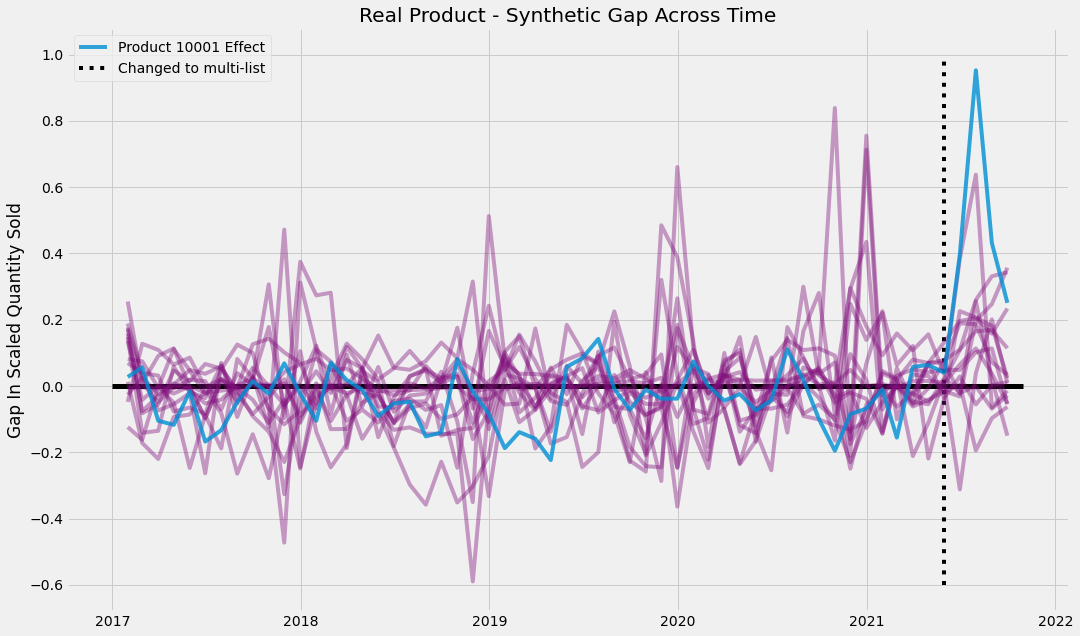

In [94]:
plt.figure(figsize=(16,10))
temp = []
score = []
for product in synthetic_products:
    if pre_treatment_mse(product) < mse_10001*4 and product.product_id.unique()!='Product 10001':
        plt.plot(product["date"], product["quantity"] - product["synthetic"], color="C5",alpha=0.4)
        
plt.plot(df.loc[df['treatment_group']==1,'date'], df.loc[df['treatment_group']==1,'quantity'] - multi_synth_lr,
         label="Product 10001 Effect",alpha=0.8)        
plt.vlines(x=pd.to_datetime(['2021-05-30']), ymin=-0.6, ymax=1, linestyle=":", lw=4, color='black', label="Changed to multi-list")
plt.hlines(y=0, xmin=pd.to_datetime(['2017-01-01']), xmax=pd.to_datetime(['2021-10-31']), lw=5, color='black')
plt.title("Real Product - Synthetic Gap Across Time")
plt.ylabel("Gap In Scaled Quantity Sold")
plt.legend();

Even though we can see in the graph above that no other product has such an extreme effect as Product 10001, we can also examine the distribution of the effects to see more clearly the total gap in the post-treatment period. 

In [95]:
multi_effect = df.loc[(df['treatment_group']==1)&(df["date"]>='2021-06-30'),'quantity'].values.sum() - multi_synth_lr[-4:].sum() 

effects = [(product.loc[(product["date"]>='2021-06-30'),'quantity'].sum() - product.loc[product['date']>='2021-06-30',"synthetic"]).values.sum()
           for product in synthetic_products
           if pre_treatment_mse(product) < mse_10001*4 and pre_treatment_mse(product) != multi_effect] # filter out noise

multi_effect = df.loc[(df['treatment_group']==1)&(df["date"]>='2021-06-30'),'quantity'].values.sum() - multi_synth_lr[-4:].sum() 

print("Multi-list Treatment Effect for the last 4 month:", multi_effect)

Multi-list Treatment Effect for the last 4 month: 2.031639443744819


In [96]:
np.mean(np.array(effects) > multi_effect)

0.0

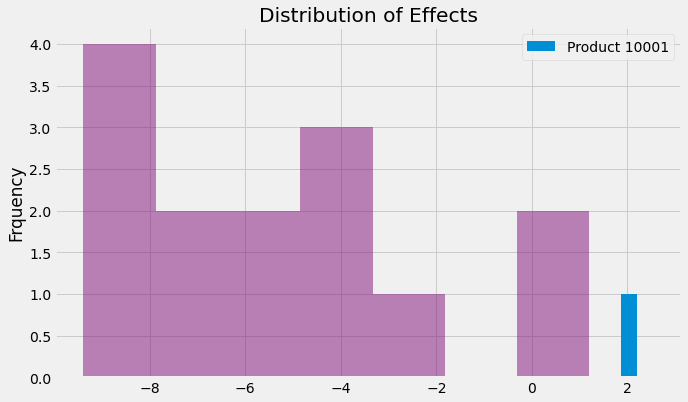

In [97]:
plt.figure(figsize=(10,6))
_, bins, _ = plt.hist(np.array(effects), bins=7, color="C5", alpha=0.5);
plt.hist([multi_effect], color="C0", label='Product 10001',bins=3)
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();